# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


# ResNet50

In [2]:
cnn_base = ResNet50(include_top=False,
                    weights="imagenet",
                    input_shape=(224, 224, 3))

model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
# model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
# model.add(Dropout(0.3))
model.add(layers.Dense(units=256, activation='relu'))
# model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
# model.add(Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))

cnn_base.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1

In [14]:
# datagen = build_datagenerator(dir1="../sample/train",
#                               dir2="../sample/aug",
#                               batch_size=16)

train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

Found 3830 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [18]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [7]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = datagen,
                              epochs = 20,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              steps_per_epoch = int(239/16)) 

Epoch 1/20
14/14 [==============================] - 400s 30s/step - loss: 22.4001 - accuracy: 0.4800 - precision: 0.6353 - recall: 0.4873 - auc: 0.5002 - auc_1: 0.7004 - val_loss: 1.0110 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.9587
Epoch 2/20
14/14 [==============================] - 374s 28s/step - loss: 2.2269 - accuracy: 0.7806 - precision: 0.8158 - recall: 0.8757 - auc: 0.7787 - auc_1: 0.8339 - val_loss: 0.3401 - val_accuracy: 0.9528 - val_precision: 0.9585 - val_recall: 0.9938 - val_auc: 0.5716 - val_auc_1: 0.9686
Epoch 3/20
14/14 [==============================] - 267s 20s/step - loss: 0.6187 - accuracy: 0.7319 - precision: 0.7621 - recall: 0.7637 - auc: 0.8001 - auc_1: 0.8161 - val_loss: 0.5077 - val_accuracy: 0.9587 - val_precision: 0.9587 - val_recall: 1.0000 - val_auc: 0.5343 - val_auc_1: 0.9640
Epoch 4/20
14/14 [==============================] - 263s 20s/step - loss: 0.3989 - accuracy: 0.8752 - precision: 0.8479 - r

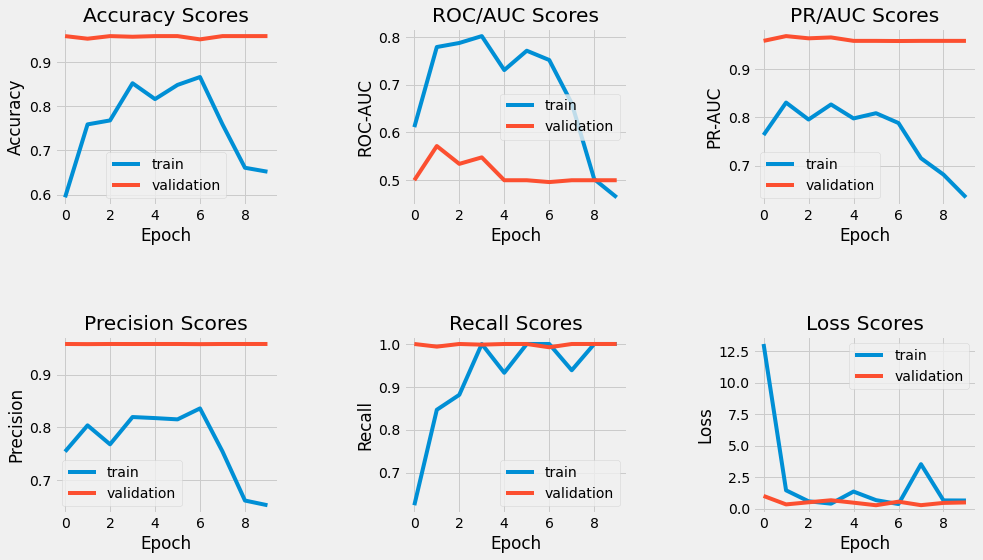

In [10]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [11]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,13.066932,0.593750,0.753846,0.624204,0.611180,0.763439,1.010977,0.958702,0.958702,1.000000,0.500000,0.958702
1,1.456697,0.758929,0.803797,0.846667,0.778829,0.830736,0.340141,0.952802,0.958457,0.993846,0.571566,0.968596
2,0.586390,0.767857,0.767742,0.881481,0.787308,0.795584,0.507677,0.958702,0.958702,1.000000,0.534258,0.963999
3,0.399267,0.852018,0.819672,1.000000,0.801690,0.826827,0.668929,0.957227,0.958641,0.998462,0.547857,0.965846
4,1.360160,0.816144,0.817647,0.932886,0.730591,0.797883,0.476334,0.958702,0.958702,1.000000,0.500000,0.958702
5,0.678386,0.848214,0.815217,1.000000,0.771081,0.808706,0.273836,0.958702,0.958702,1.000000,0.500000,0.958702
6,0.368293,0.866071,0.836066,1.000000,0.751634,0.788333,0.556477,0.951327,0.958395,0.992308,0.496154,0.958396
7,3.531058,0.758929,0.754098,0.938776,0.660880,0.715321,0.279850,0.958702,0.958702,1.000000,0.500000,0.958702
8,0.656139,0.660714,0.660714,1.000000,0.502312,0.681433,0.458720,0.958702,0.958702,1.000000,0.500000,0.958702
9,0.648896,0.651786,0.651786,1.000000,0.464173,0.634199,0.497049,0.958702,0.958702,1.000000,0.500000,0.958702


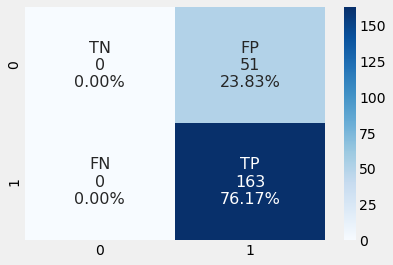

In [22]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

# AlexNet

In [24]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(224, 224, 3, )))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('sigmoid'))

#Model Summary
AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_9 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
activation_9 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_10 (Activation)   (None, 28, 28, 256)      

In [27]:
AlexNet.compile(loss = 'binary_crossentropy',
                optimizer = Adam(learning_rate=0.01),
                # optimizer = RMSprop(lr=2e-5),
                metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [28]:
filepath = '../models/Alexnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history2 = AlexNet.fit_generator(generator = train_generator,
                                 epochs = 10,
                                 callbacks = [earlyStopping, mcp_save],
                                 validation_data = val_generator,
                                 steps_per_epoch = int(239/16)) 

Epoch 1/10
14/14 [==============================] - 535s 40s/step - loss: 0.5865 - accuracy: 0.7179 - precision_2: 0.7801 - recall_2: 0.7400 - auc_4: 0.7494 - auc_5: 0.7572 - val_loss: 1481457.8750 - val_accuracy: 0.0413 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_4: 0.5000 - val_auc_5: 0.9587
Epoch 2/10
14/14 [==============================] - 496s 37s/step - loss: 0.4780 - accuracy: 0.8467 - precision_2: 0.8252 - recall_2: 0.9911 - auc_4: 0.8594 - auc_5: 0.9251 - val_loss: 68176.4844 - val_accuracy: 0.0413 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_4: 0.5000 - val_auc_5: 0.9587
Epoch 3/10
14/14 [==============================] - 656s 50s/step - loss: 0.4107 - accuracy: 0.8594 - precision_2: 0.8321 - recall_2: 0.9890 - auc_4: 0.9230 - auc_5: 0.9512 - val_loss: 1937.2653 - val_accuracy: 0.0413 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_4: 0.5000 - val_auc_5: 0.9587
Epoch 4/10
14/14 [==============================] -

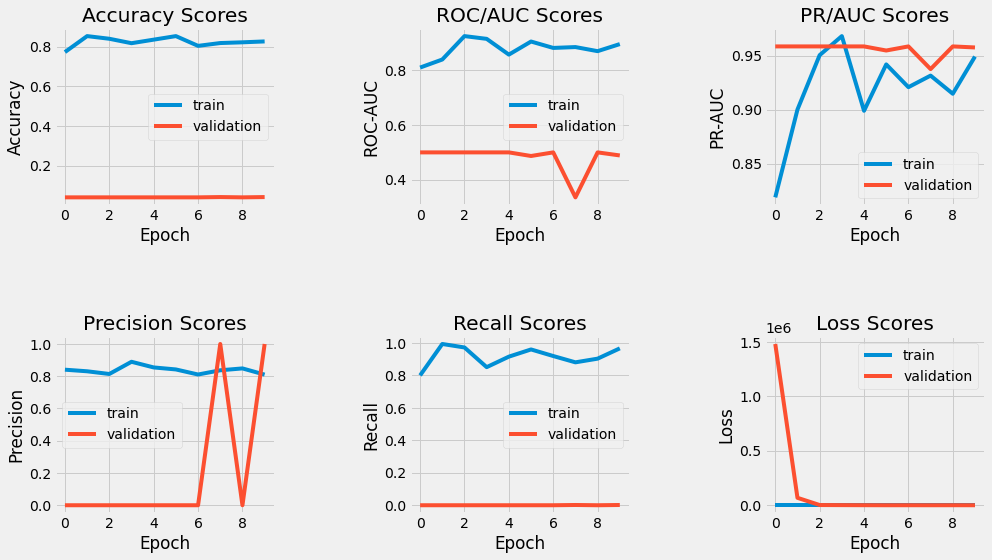

In [30]:
sixplot(history2, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

In [31]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_2,recall_2,auc_4,auc_5,val_loss,val_accuracy,val_precision_2,val_recall_2,val_auc_4,val_auc_5
0,0.526756,0.772321,0.840580,0.800000,0.810301,0.818782,1.481458e+06,0.041298,0.0,0.000000,0.500000,0.958702
1,0.475467,0.852679,0.830688,0.993671,0.839758,0.900164,6.817648e+04,0.041298,0.0,0.000000,0.500000,0.958702
2,0.404099,0.839286,0.813953,0.972222,0.925391,0.950601,1.937265e+03,0.041298,0.0,0.000000,0.500000,0.958702
3,0.411577,0.816964,0.889610,0.850932,0.915311,0.968259,1.121600e+03,0.041298,0.0,0.000000,0.500000,0.958702
4,0.409318,0.834821,0.854545,0.915584,0.857699,0.899029,4.238093e+02,0.041298,0.0,0.000000,0.500000,0.958702
5,0.383294,0.852679,0.842105,0.960000,0.905541,0.942021,3.121670e+01,0.041298,0.0,0.000000,0.486841,0.954900
6,0.400937,0.803571,0.810651,0.919463,0.882148,0.920921,1.553907e+02,0.041298,0.0,0.000000,0.500000,0.958702
7,0.423220,0.817757,0.836879,0.880597,0.885261,0.931641,3.877418e+00,0.042773,1.0,0.001538,0.335495,0.937682
8,0.397718,0.821429,0.848485,0.903226,0.870313,0.914815,2.510311e+02,0.041298,0.0,0.000000,0.500000,0.958702
9,0.384926,0.825893,0.810056,0.966667,0.896171,0.949304,4.143155e+01,0.042773,1.0,0.001538,0.488819,0.957727


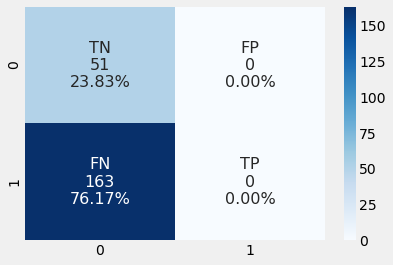

In [32]:
probabilities = AlexNet.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)